In [1]:
import pandas as pd

In [155]:
# Define list of diseases for analysis
diseases = ['Alzheimer_disease', 'Colon_cancer', 'Ewing_sarcoma', 'Rheumatoid_arthritis',
            'Severe_myoclonic_epilepsy_in_infancy', 'Primary_biliary_cholangitis']

# 1. Creating dictionaries containing the genes for pathway enrichment analysis

In [144]:
# Getting disease associated genes from DisGeNET for pathway enrichment analysis

disgenet_path = '../00_Data/DisGeNET_seeds' # Specifying path to the disease associated genes according to DisGeNET
disgenet_seeds = {}
num_genes = 30 # Specify the amount of genes that shall be chosen for analysis
for _ in diseases:
    p = f'{disgenet_path}/{_}_seeds.txt' # Opening file containign associated genes for specific disease
    df = pd.read_csv(p, names = ['genes']) # Reading into dataframe
    ls = list(df['genes'][:num_genes]) # Selecting specified amoung of genes for analysis
    if len(ls) < num_genes: # Indication, if list is too short
        print(f'Length of list is only {len(ls)}')
    disgenet_seeds[_] = ls # All diseases and their respective gene sets get added to a dictionary

In [145]:
# Getting top disease associated genes from RWR on genetic multiplex network for pathway enrichment analysis

disgenet_path = '../00_Data/RWR_results/rwr_ranking_seeds_30_gene-multiplex-130924'
gene_multiplex_rwr = {}
num_genes = 50 # Specify the amount of genes that shall be chosen for analysis
for _ in diseases:
    p = f'{disgenet_path}/rwr_ranking_{_}_seeds_30_gene-multiplex-130924.csv'
    df = pd.read_csv(p, sep = '\t')
    df.sort_values(by = 'score', inplace = True, ascending = False) # Genes are sorted by their visiting probabilities
    ls = list(df['node'][:num_genes])
    gene_multiplex_rwr[_] = ls

In [146]:
# Getting top disease associated genes from RWR on multiplex heterogeneous network for pathway enrichment analysis

disgenet_path = '../00_Data/RWR_results/rwr_ranking_seeds_30_het_multiplex_dis_0209_gene_1309_gene_results'
het_multiplex_rwr = {}
num_genes = 50 # Specify the amount of genes that shall be chosen for analysis
for _ in diseases:
    p = f'{disgenet_path}/rwr_ranking_{_}_seeds_30_het_multiplex_dis_0209_gene_1309_gene_results.csv'
    df = pd.read_csv(p, sep = '\t')
    df.sort_values(by = 'score', inplace = True, ascending = False) # Genes are sorted by their visiting probabilities
    ls = list(df['node'][:num_genes])
    het_multiplex_rwr[_] = ls

In [147]:
# Getting top disease associated genes from RWR on protein-interaction network for pathway enrichment analysis

disgenet_path = '../00_Data/RWR_results/rwr_ranking_seeds_30_ppi'
ppi_rwr = {}
num_genes = 50 # Specify the amount of genes that shall be chosen for analysis
for _ in diseases:
    p = f'{disgenet_path}/rwr_ranking_{_}_seeds_30_ppi.csv'
    df = pd.read_csv(p, sep = '\t')
    df.sort_values(by = 'score', inplace = True, ascending = False) # Genes are sorted by their visiting probabilities
    ls = list(df['node'][:num_genes])
    ppi_rwr[_] = ls

# 2. Enrichment analysis

Done according to: https://maayanlab.cloud/Enrichr/help#api

In [148]:
import json
import requests
import time

In [149]:
# Uploading the set of genes to then be called for the enrichment analysis

def upload_gene_set(gene_list, set_description):
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(gene_list)

    payload = {
        'list': (None, genes_str),
        'description': (None, set_description)
    }
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    
    data = json.loads(response.text)
    return data

In [150]:
# Downloading the analysis results of the enrichment

def download_results(user_list_id, gene_set_library, filename):
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/export'
    query_string = '?userListId=%s&filename=%s&backgroundType=%s'
    
    url = ENRICHR_URL + query_string % (user_list_id, filename, gene_set_library)
    response = requests.get(url, stream=True)
    
    with open(filename + '.txt', 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)

In [161]:
# Perform analysis with enrichr

def enrichr_analysis(
    gene_list: list,
    set_description: str,
    libraries: list = ['KEGG_2021_Human', 'Reactome_2022', 'GO_Biological_Process_2023'], 
    ):
    
    data = upload_gene_set(gene_list,set_description) # Uplaoding the gene sets
    for library in libraries:
        filename = f'{set_description}_{library}' # Creating the filename for the file to save the results in
        # Downloading the enrichment results
        download_results(user_list_id = data['userListId'], gene_set_library = library, filename = f'../00_Data/Enrichment_results/{filename}')
        time.sleep(5) # spacing out requests

In [162]:
# Iterating through the dictionaries and getting enrichment results
for _ in disgenet_seeds:
    enrichr_analysis(gene_list=disgenet_seeds[_], set_description=f'disgenet_{_}', libraries=['KEGG_2021_Human'])

KeyboardInterrupt: 

# 3. Plot the results

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Loading the results of the enrichments for the different associated gene sets for a specific disease 

def load_results(disease):
    p1 = f'../00_data/Enrichment_results/disgenet_{disease}_KEGG_2021_Human.txt' # enrichment of associated genes from DisGeNET
    df1 = pd.read_csv(p1, sep = '\t', index_col = 0)
    
    p2 = f'../00_data/Enrichment_results/gene_multiplex_RWR_{disease}_KEGG_2021_Human.txt' # enrichment of genes from RWR on the genetic multiplex
    df2 = pd.read_csv(p2, sep = '\t', index_col = 0)
    
    p3 = f'../00_data/Enrichment_results/het_multiplex_RWR_{disease}_KEGG_2021_Human.txt' # enrichment of genes from RWR on the multiplex-heterogeneous network
    df3 = pd.read_csv(p3, sep = '\t', index_col = 0)
    
    p4 = f'../00_data/Enrichment_results/ppi_RWR_{disease}_KEGG_2021_Human.txt' # enrichment of genes from RWR on the protein-interaction network
    df4 = pd.read_csv(p4, sep = '\t', index_col = 0)

    return df1, df2, df3, df4 # Returning the dataframes of the results

In [ ]:
# Select the top disease associated pathways, by default it will be the top 5

def top_pathways(df, num_of_pathways = 5):
    df.sort_values(by = 'Adjusted P-value', ascending = True, inplace = True) # sorting by adjusted p-value
    top = df.index[:num_of_pathways] # list of top pathways
    top_p_values = df['Adjusted P-value'][:num_of_pathways]  # Adjsuted p-values of the top pathways
    return list(top), list(top_p_values)

In [ ]:
# Splitting the label in the middle for design purposes

def split_label_in_middle(label):

    words = label.split(' ') # Get a list of words in the pathway name
    
    if len(words) > 1: # Only split if the pathway name is at least two words long
        mid = len(words) // 2  # Finding the middle index to split
        return ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:]) # Joining the first half and second half with a newline in between
    
    else:
        # If there are no spaces or just one word, return the original label
        return label

In [ ]:
# Function for plotting the top enriched pathways for every method and highlighting the signficance of enrichment

def plot_top(t1, p1, t2, p2, t3, p3, t4, p4, disease, save_fig=None):

    all_top_pathways = set(t1 + t2 + t3 + t4) # Combining the top pathways into a single set (to remove duplicates)
    all_top_pathways = list(all_top_pathways) # Converting the set to a list to use as an index for the DataFrame
    
    # Creating a DataFrame for ranks and one for p-values
    heatmap_data_ranks = pd.DataFrame(np.nan, index=all_top_pathways, columns=['DisGeNet seeds', 'Gene-multiplex', 'Multiplex-heterogeneous\nnetwork', 'Protein interaction\nnetwork'])
    heatmap_data_pvalues = pd.DataFrame(np.nan, index=all_top_pathways, columns=['DisGeNet seeds', 'Gene-multiplex', 'Multiplex-heterogeneous\nnetwork', 'Protein interaction\nnetwork'])
    
    # Fill both dataframes with ranks and p-values respectively
    for i, (pathway, p_value) in enumerate(zip(t1, p1)):
        heatmap_data_ranks.loc[pathway, 'DisGeNet seeds'] = i + 1
        heatmap_data_pvalues.loc[pathway, 'DisGeNet seeds'] = p_value
        
    for i, (pathway, p_value) in enumerate(zip(t2, p2)):
        heatmap_data_ranks.loc[pathway, 'Gene-multiplex'] = i + 1
        heatmap_data_pvalues.loc[pathway, 'Gene-multiplex'] = p_value
        
    for i, (pathway, p_value) in enumerate(zip(t3, p3)):
        heatmap_data_ranks.loc[pathway, 'Multiplex-heterogeneous\nnetwork'] = i + 1
        heatmap_data_pvalues.loc[pathway, 'Multiplex-heterogeneous\nnetwork'] = p_value
        
    for i, (pathway, p_value) in enumerate(zip(t4, p4)):
        heatmap_data_ranks.loc[pathway, 'Protein interaction\nnetwork'] = i + 1
        heatmap_data_pvalues.loc[pathway, 'Protein interaction\nnetwork'] = p_value


    heatmap_data_log_pvalues = -np.log10(heatmap_data_pvalues) # adjusted p-values are converted to -log10(p-value)
    
    # Adjusting the ranks dataframe to get the correct order of pathways
    heatmap_data_filled = heatmap_data_ranks.fillna(6) # NaN values are then replaced with 6
    heatmap_data_filled['Sum'] = (heatmap_data_filled).sum(axis=1)   # Adding a column to count sum of the ranks for each pathway
    heatmap_data_sorted = heatmap_data_filled.sort_values(by='Sum', ascending=True) # Sorting the pathways by how often they appear with high significance (= descending order)
    df_order = list(heatmap_data_sorted.index) # Get the order of the pathways by their relevance

    # Adjsuting also the order of the p-values dataframe
    heatmap_data_log_pvalues_sorted = heatmap_data_log_pvalues.reindex(df_order) # Reorder the heatmap based on the ranks

    heatmap_data_sorted = heatmap_data_sorted.drop(columns=['Sum']) # Dropping the column counting the sum of ranks
    
    # Converting the ranks to strings to have text annotations in the heatmap
    annotations = heatmap_data_sorted.copy().map(lambda x: str(int(x)) if pd.notna(x) else np.nan)

    # Modify y-tick labels: Split each pathway label at the middle space
    ytick_labels = [split_label_in_middle(label) for label in df_order]

    # Transpose the heatmap to have the gene sets on the y-axis and the pathways on the x-axis
    heatmap_data_log_pvalues_sorted_T = heatmap_data_log_pvalues_sorted.T
    annotations_T = annotations.T

    # Plot the heatmap with p-values for color and ranks for annotations
    width = len(annotations) + 1
    plt.figure(figsize=(width, 5))
    
    ax = sns.heatmap(heatmap_data_log_pvalues_sorted_T, annot=annotations_T, fmt='', cmap='viridis', linewidths=0.5, 
                     cbar_kws={'label': '-log10(Adjusted P-value)', 'pad': 0.02}, square=True, annot_kws = {'fontsize': 19})
    
    # Adjust font size of color bar label
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Adjust the font size of the color bar label
    cbar.ax.tick_params(labelsize=16)  # Adjust the font size of the color bar ticks

    # Adjusting the tick labels
    plt.xticks(rotation=0, ha='right', fontsize = 18)
    plt.gca().set_xticklabels(ytick_labels, rotation=45, ha='right', fontsize = 16) # Setting the pathway names (formerly the y-axis labels) as labels for the x-axis
    
    if disease == 'Severe_myoclonic_epilepsy_in_infancy': # Change severe myoclonic epilepsy in infancy to the more common name dravet syndrome and set as title
        plt.title('Dravet syndrome', fontsize = 20)
    else:
        plt.title(disease.replace('_', ' '), fontsize = 20) # Remove _ in the disease names and set them as titles
    plt.yticks(fontsize = 17)
    
    # Save figure if needed
    if save_fig:
        plt.savefig(save_fig, format='pdf', bbox_inches='tight')
        
    plt.show()


In [159]:
# Function executing all steps for plotting
def plot_enrichment_results(disease, save_fig = None):

    df1, df2, df3, df4 = load_results(disease) # Loading the dataframes of enrichment results for a specific diseases
    
    # Getting the top pathways for each dataframe
    t1, p1 = top_pathways(df1, num_of_pathways = 5)
    t2, p2 = top_pathways(df2, num_of_pathways = 5)
    t3, p3 = top_pathways(df3, num_of_pathways = 5)
    t4, p4 = top_pathways(df4, num_of_pathways = 5)

    plot_top(t1, p1, t2, p2, t3, p3, t4, p4, disease, save_fig) # Plot


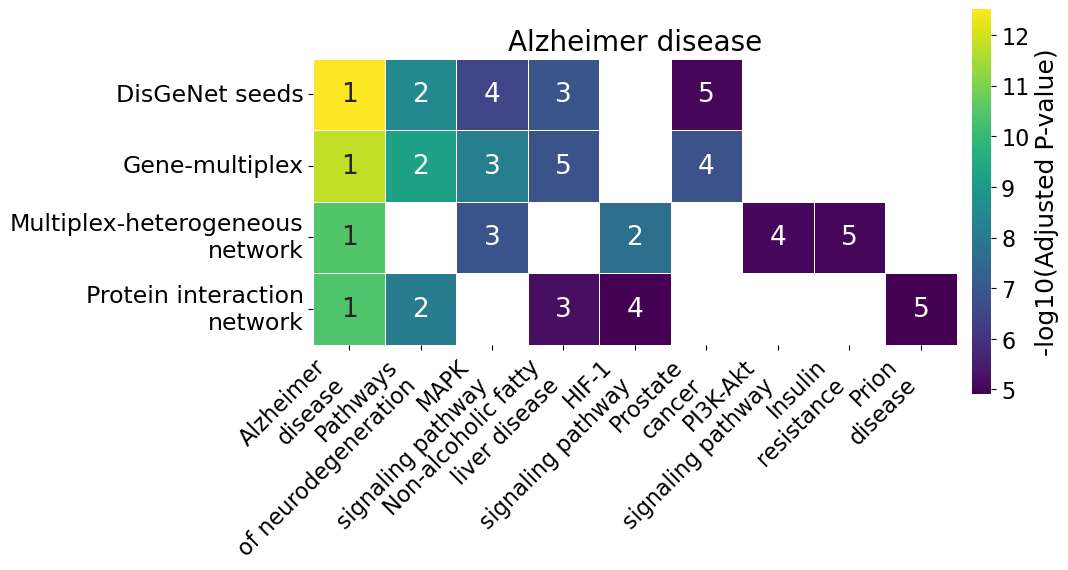

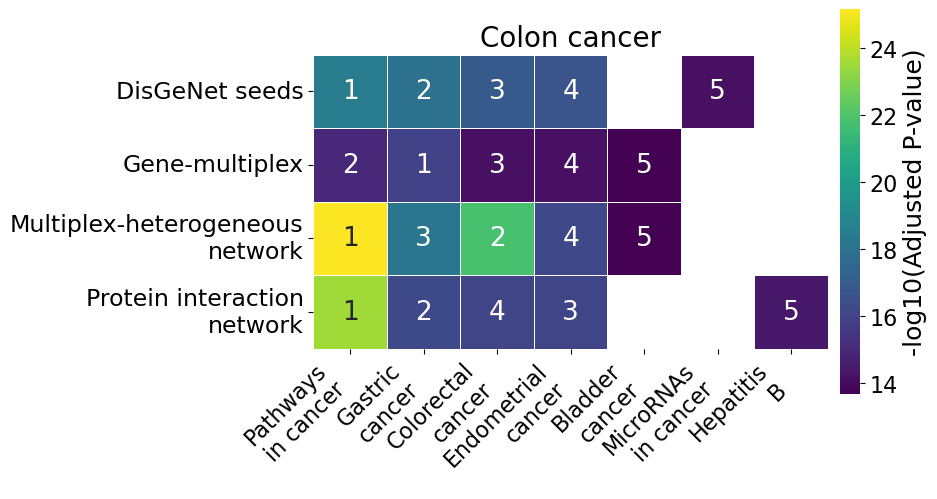

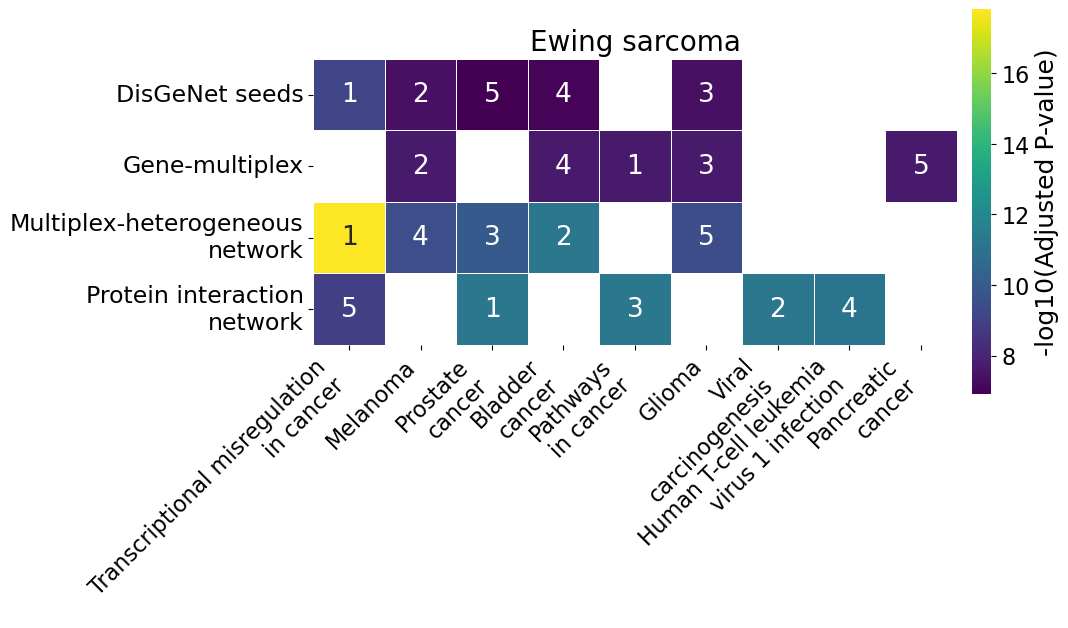

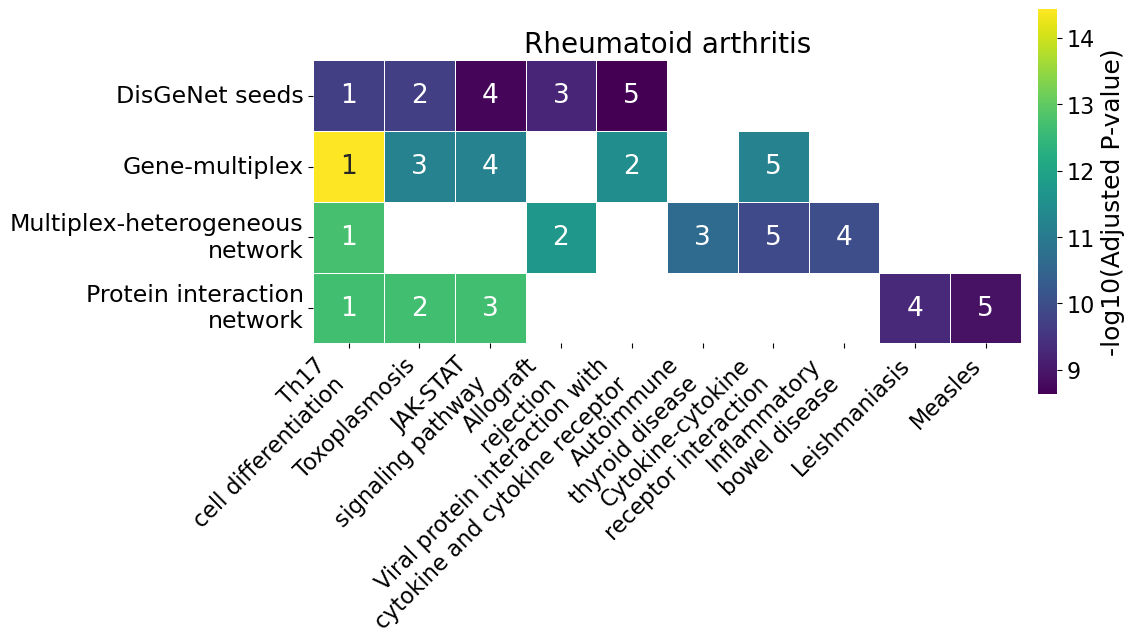

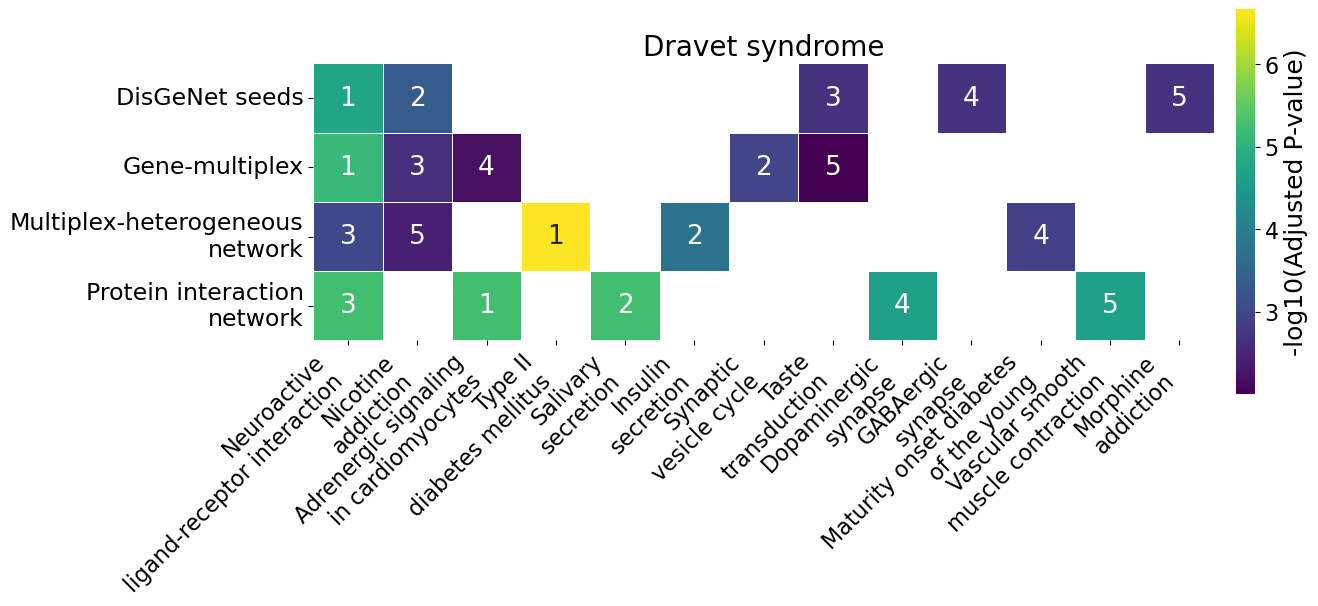

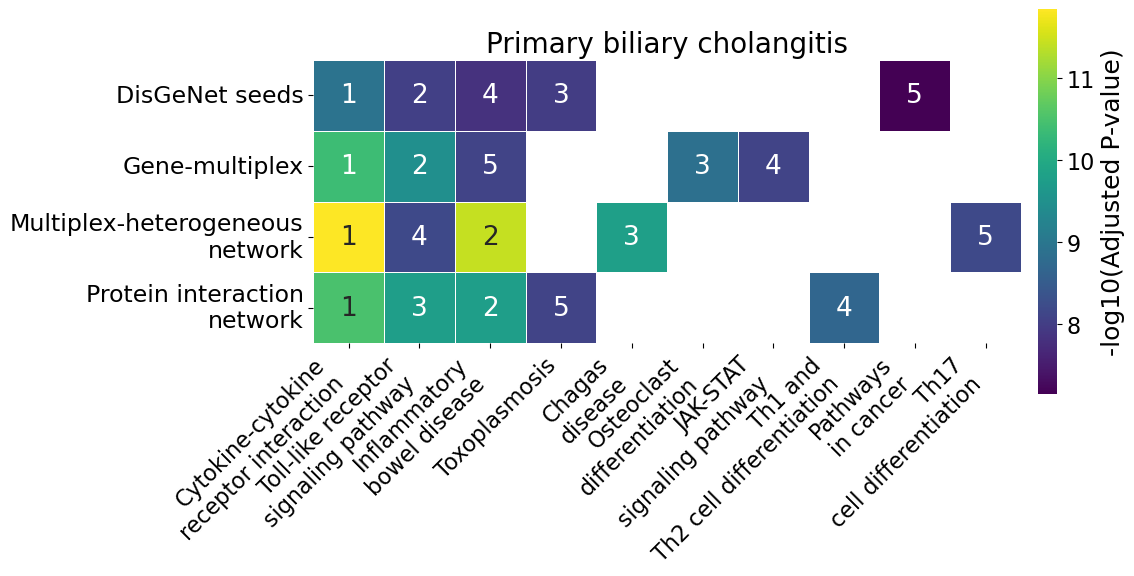

In [158]:
# Creating the plots
for disease in diseases:
    y = plot_enrichment_results(disease)